In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

In [2]:
df = pd.read_csv('train.csv',nrows=20000)

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df.shape

(20000, 8)

In [5]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.097350,0.011100,0.053850,0.003350,0.051050,0.009050
std,0.296441,0.104773,0.225727,0.057784,0.220105,0.094702
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
%timeit True if 1 in df.loc[0][['toxic','severe_toxic','obscene','threat','insult','identity_hate']] else False

589 µs ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%timeit any(i == 1 for i in df.loc[0][['toxic','severe_toxic','obscene','threat','insult','identity_hate']])

587 µs ± 22.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
df['target'] = df.apply(lambda x: any(i == 1 for i in x[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]), axis=1)

In [9]:
df = df.drop(['id','toxic','severe_toxic','obscene','threat','insult','identity_hate'],axis=1)

In [10]:
df.head(10)

,comment_text,target
0,Explanation\nWhy the edits made under my usern...,False
1,D'aww! He matches this background colour I'm s...,False
2,"Hey man, I'm really not trying to edit war. It...",False
3,"""\nMore\nI can't make any real suggestions on ...",False
4,"You, sir, are my hero. Any chance you remember...",False
5,"""\n\nCongratulations from me as well, use the ...",False
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True
7,Your vandalism to the Matt Shirvington article...,False
8,Sorry if the word 'nonsense' was offensive to ...,False
9,alignment on this subject and which are contra...,False


In [11]:
test = pd.read_csv('test.csv')

In [12]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [13]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [15]:
vec = TfidfVectorizer(max_features=1000,ngram_range=(1,3), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1,stop_words='english')
trn_term_doc = vec.fit_transform(df['comment_text'])
test_term_doc = vec.transform(test['comment_text'])

In [16]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [17]:
train = pd.DataFrame(trn_term_doc.toarray(), 
                    columns=vec.get_feature_names())

In [18]:
test = pd.DataFrame(test_term_doc.toarray(), 
                    columns=vec.get_feature_names())

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train, df['target'], test_size=0.2, random_state=0)

In [20]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, y_pred)
print('Accuracy is:',score)
f1 = metrics.f1_score(y_test, y_pred)
print('F score is:',f1)

Accuracy is: 0.74175
F score is: 0.40392383150605893


In [21]:
recall = metrics.recall_score(y_test, y_pred)
print('Recall score is:',recall)

Recall score is: 0.8393285371702638


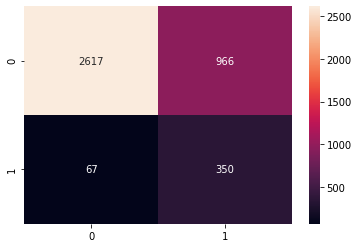

In [24]:
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='2.0f')

In [23]:
svm = svm.SVC()
y_pred2 = svm.fit(X_train, y_train).predict(X_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, y_pred2)
print('Accuracy for SVC is:',score)
f1 = metrics.f1_score(y_test, y_pred2)
print('F score for SVC is:',f1)
recall = metrics.recall_score(y_test, y_pred2)
print('Recall score for SVC is:',recall)


Accuracy for SVC is: 0.93525
F score for SVC is: 0.5632377740303541
Recall score for SVC is: 0.40047961630695444


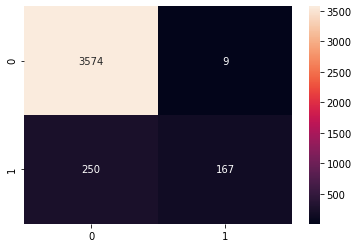

In [27]:
sns.heatmap(metrics.confusion_matrix(y_test,y_pred2),annot=True,fmt='2.0f')

In [25]:
rf = RandomForestClassifier()
y_pred3 = rf.fit(X_train, y_train).predict(X_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, y_pred3)
print('Accuracy for RandomForestClassifier is:',score)
f1 = metrics.f1_score(y_test, y_pred3)
print('F score for RandomForestClassifier is:',f1)
recall = metrics.recall_score(y_test, y_pred3)
print('Recall score for RandomForestClassifier is:',recall)

Accuracy for RandomForestClassifier is: 0.93525
F score for RandomForestClassifier is: 0.5788617886178862
Recall score for RandomForestClassifier is: 0.42685851318944845


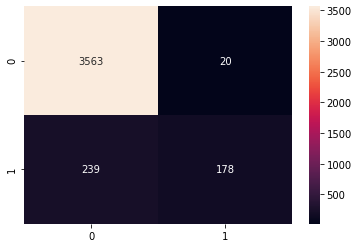

In [26]:
sns.heatmap(metrics.confusion_matrix(y_test,y_pred3),annot=True,fmt='2.0f')